### 组合优化策略比较分析与纯代码框架介绍

在股票市场上的交易过程实际上就是配股过程，那么怎样的组合可以降低风险提高收益呢？

我们这里以申万行业指数数据为数据源讨论一下组合优化的几个策略并提供一个纯代码的框架



### 1) 所需库的加载

In [1]:
# Load the packages
# 调用包的部分

import pandas as pd  #金融数据处理包
import numpy as np   #数学包
import seaborn as sns  #数据可视化包
import matplotlib as mpl   #数据可视化包
from cvxopt import solvers, matrix  #优化包
import datetime as dt   #时间对象
import re #正则表达式
from scipy.optimize import minimize  #优化包
from matplotlib import pyplot as plt #画图

print('Package successfully loaded')

Package successfully loaded


### 2）获取行业的日频行情列表

In [3]:
# Get the SW industry index chart
# 获得行业指数价格时间序列表

def Get_SW_Industry_Index_CN(date1,date2):
    
    # 获取行业指数代码和名称对照表
    hy_df = DataSource('basic_info_IndustrySw').read()
    hy_df = hy_df[hy_df['industry_sw_level']==1]    # 我们用的是一级行业指数
    hy_df['code']=hy_df['code'].apply(lambda x:str('SW'+x+'.HIX'))  # 我们需要对行业指数字符串做改动方便和后面的join
    
    X = DataSource('basic_info_index_CN_STOCK_A').read()
    
    # X here is all of the indexes and we need to filter the SW index out
    X['flag'] = X['instrument'].apply(lambda x:x[:2]) 
    X=X[X['flag']=='SW']
    
    # Then using The names from X and date1,date2 we can get the datasource Y as timeseries of thoese indexes now
    Y=DataSource('bar1d_index_CN_STOCK_A').read(start_date=date1,end_date=date2,instruments=list(X['instrument']))
    #Y['instrument'] = Y['instrument'].apply(lambda x:re.findall("\d+",x)[0])
    # 这里我们无法在图上用matplotlib标出中文，但是代码可以
    Y=Y.merge(hy_df,how='inner',left_on='instrument',right_on='code')
    
    
    # Do the pivot to transform the chart
    Y_Industry = pd.pivot_table(Y,values='close',index='date',columns='name')
    
    hy_df = pd.DataFrame(Y_Industry.columns)
    return Y_Industry,hy_df

def Get_SW_Industry_Index_EN(date1,date2):
    
    # 获取行业指数代码和名称对照表
    hy_df = DataSource('basic_info_IndustrySw').read()
    hy_df = hy_df[hy_df['industry_sw_level']==1]    # 我们用的是一级行业指数
    hy_df['code']=hy_df['code'].apply(lambda x:str('SW'+x+'.HIX'))  # 我们需要对行业指数字符串做改动方便和后面的join
    
    X = DataSource('basic_info_index_CN_STOCK_A').read()
    
    # X here is all of the indexes and we need to filter the SW index out
    X['flag'] = X['instrument'].apply(lambda x:x[:2]) 
    X=X[X['flag']=='SW']
    
    # Then using The names from X and date1,date2 we can get the datasource Y as timeseries of thoese indexes now
    Y=DataSource('bar1d_index_CN_STOCK_A').read(start_date=date1,end_date=date2,instruments=list(X['instrument']))
    Y['instrument'] = Y['instrument'].apply(lambda x:re.findall("\d+",x)[0])
    # 这里我们无法在图上用matplotlib标出中文，但是代码可以
    #Y=Y.merge(hy_df,how='inner',left_on='instrument',right_on='code')
    
    # Do the pivot to transform the chart
    Y_Industry = pd.pivot_table(Y,values='close',index='date',columns='instrument')
    return Y_Industry
start_date = '2020-01-01'
end_date = '2021-08-01'
SW_Index_C,hy_df = Get_SW_Industry_Index_CN(start_date,end_date)
SW_Index_E = Get_SW_Industry_Index_EN(start_date,end_date)
SW_Index_E.head()

instrument,110000,210000,220000,230000,240000,270000,280000,330000,340000,350000,...,490000,510000,610000,620000,630000,640000,650000,710000,720000,730000
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3394.960938,2536.514893,2744.548096,2150.931885,3080.884033,3601.217041,3988.844971,7995.194824,15350.150391,1964.907959,...,2158.428955,2157.916992,6426.745117,2137.648926,4457.709961,1196.994995,1144.331055,4801.248047,709.890015,2352.385986
2020-01-03,3425.510986,2553.162109,2759.427002,2144.841064,3130.582031,3618.873047,3998.722900,7876.439941,15055.030273,1961.338013,...,2159.522949,2155.384033,6363.964844,2144.622070,4479.981934,1197.833984,1166.557983,4830.903809,720.299011,2379.785889
2020-01-06,3494.012939,2610.611084,2773.022949,2135.625977,3231.064941,3665.729004,4008.747070,7786.027832,14938.759766,1954.918945,...,2150.249023,2185.802979,6346.974121,2146.843994,4529.538086,1199.546021,1183.363037,4883.988770,731.008972,2392.708984
2020-01-07,3624.719971,2626.649902,2786.179932,2179.709961,3205.709961,3663.959961,4063.649902,7910.890137,15155.379883,1972.040039,...,2167.090088,2221.820068,6384.310059,2161.120117,4578.040039,1210.589966,1189.489990,4988.350098,754.080017,2413.639893
2020-01-08,3559.930908,2595.822998,2746.783936,2132.660889,3207.267090,3619.105957,4101.225098,7975.007812,15094.250000,1931.302002,...,2114.642090,2189.422119,6278.363770,2127.260986,4570.019043,1194.913940,1218.703979,4902.416016,734.393005,2358.787109


### 3）对行业数据进行画图比较分析

画出动态图


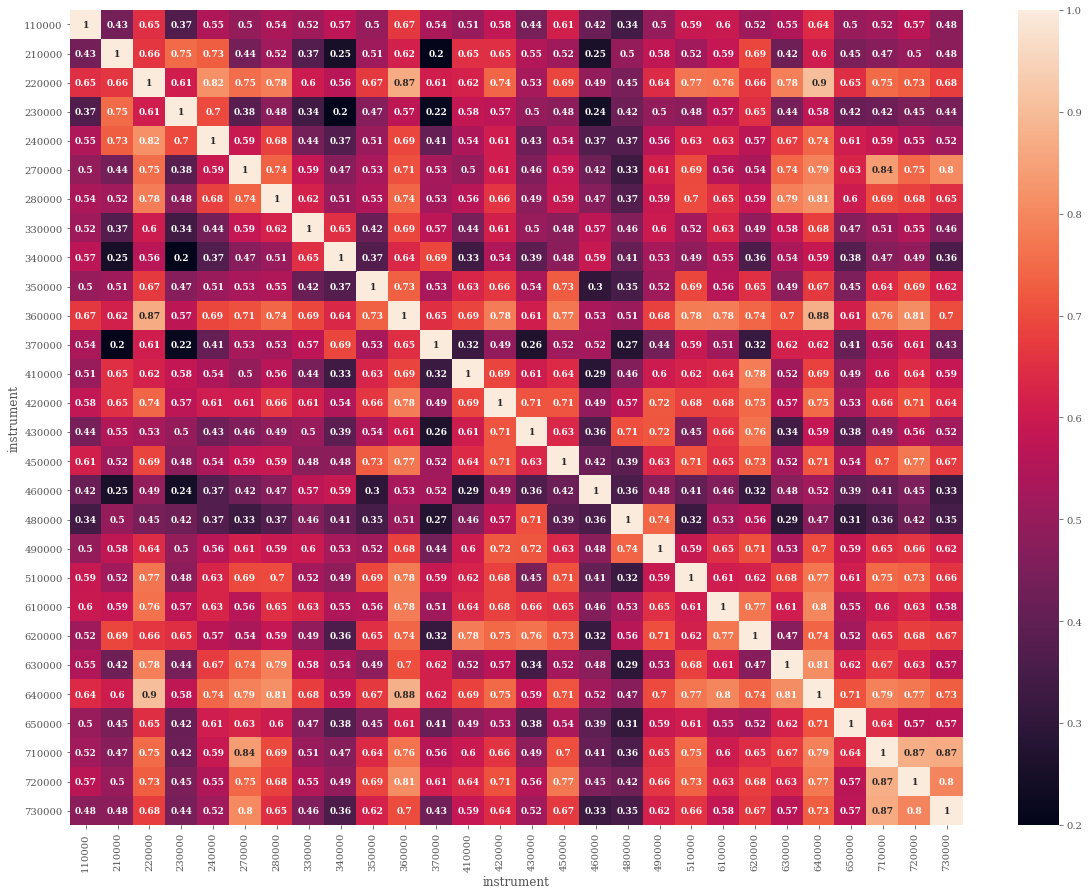

In [4]:
# Plot the Sw industry indexes and the correlation matrix
# 画图

mpl.pyplot.style.use('ggplot')
mpl.rcParams['font.family']='serif'
mpl.rcParams['axes.unicode_minus']=False # 处理负号

prices=SW_Index_C
pct_daily = prices.pct_change()

print('画出动态图')
T.plot(prices/prices.iloc[0],title='行业指数收盘价', chart_type='line',options={'chart':{'height':800}})
prices=SW_Index_E
pct_daily = prices.pct_change()
# Plot the correlation matrix,  No use at all actually
fig = plt.figure(figsize= (20,15))
ax = fig.add_subplot(111)
ax = sns.heatmap(pct_daily.corr(),annot=True,annot_kws={'size':9,'weight':'bold'})


#### 4） 交易日期与频次的选择
本部分提供了很多灵活变化的可能，我们可以修改交易频次，甚至可以在其中加上择时的因素将策略结合起来使用

In [5]:
# 我们做行业轮动计划每个月重新配置一下，用过往90天的历史数据
# Get the trade days

Frequency = 30

def Get_Trade_day_with_frequency(frequency):
    Trade_day = D.trading_days(start_date=start_date,end_date=end_date)
    Trade_day_F = Trade_day[0:-1:frequency]
    return Trade_day_F

tradedays = Get_Trade_day_with_frequency(Frequency)
tradedays['date'] = tradedays['date'].apply(lambda x:pd.to_datetime(x).strftime('%Y-%m-%d'))
tradedays = tradedays['date']

# 需要知道的是我们的数据并不足以支撑我们向前回溯2005年前的120天，所以，我们需要再往后取几个
tradedays = tradedays[3:]
tradedays.head()

3736    2020-05-21
3766    2020-07-06
3796    2020-08-17
3826    2020-09-28
3856    2020-11-17
Name: date, dtype: object

### 5）组合优化实现 

In [6]:
#计算调仓时权重配置并保存为字典
# Calculate the weights then save them as weights_dict

#记录加入权重后的组合收益时间序列
# Record the return timeseries

# 这些很重要，都是主要的数据存储部分

t0 = dt.datetime.now()  # Get the orginal time for the codes 存储了程序运行开始时间，用于后面输出整体的运行时间
weights_dict = {} # 存储权重信息，Store the weights information， 权重的变化是策略的核心
returns_df = pd.DataFrame()  # 存储组合收益率信息,store the portfolio information
num = 1  # num here is just a process control  num在这里只是一个控制变量
ret_daily = pct_daily+1 #(We need the 1+r%, not r%)
weights_name = ['mean_weights','mean_vol','min_var','risk_parity']  # 四种不同的思路


# 因为我们是在固定时点交易，因此我们仅仅存储那些天的头寸，  We only need to make our decisions at certain time.
for date_temp1,date_temp2 in zip(tradedays[:-1],tradedays[1:]):
    
    t1=dt.datetime.now()
    
    #获取指定日期前的交易日日期
    def get_before_tradeday(date,n):
        
        today = date
        
        # We transfer the type from str to datetime then back becasue we need to find the historical period
        today_datetime = datetime.datetime.strptime(today,"%Y-%m-%d")
        past_datetime = today_datetime - datetime.timedelta(days=n)
        past = past_datetime.strftime("%Y-%m-%d")
        
        return past
    
    date_before = get_before_tradeday(date_temp1,250)
    
    #最小方差
    def fun1(x):
        
        # Here risk is the total risk of a portfolio
        # 这里的风险是一个对投资组合风险的总衡量
        risk =  np.dot(x.T,np.dot(cov_mat,x))
        return risk
    
    
    #风险平价
    def fun3(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    #计算协方差矩阵
    pct_temp = pct_daily.loc[date_before:date_temp1,:]
    cov_mat = pct_temp.cov()
    omega = np.matrix(cov_mat.values)
    
    #sicpy优化方法参数设置
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})   # 投资组合权重加总为1
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
    
    #平均分配权重
    weights1 = np.array([1.0/pct_temp.shape[1]]*pct_temp.shape[1])
    #等波动率
    wts = 1/pct_temp.std()
    weights2 = wts/wts.sum()
    #模型求解组合方差最小时权重
    weights3 = minimize(fun1,x0,bounds=bnds,constraints=cons,method='SLSQP',options=options)['x']
    #风险平价
    weights4 = minimize(fun3,x0,bounds=bnds,constraints=cons,method='SLSQP',options=options)['x']
    weights_list = [weights1,weights2,weights3,weights4]
    #统计收益
    if num == 0:
        returns1_df = pd.DataFrame()
        for i in range(len(weights_list)):
            weights_temp =[j if j > 0.0001 else 0.0 for j in weights_list[i]]
            returns1_df[weights_name[i]] = (ret_daily.loc[date_temp1:date_temp2,:]*weights_temp).cumsum(axis=1).iloc[:,-1]
        returns_df = pd.concat([returns_df,returns1_df],axis=0)
    else:
        #按权重的方式计算
        for i in range(len(weights_list)):
            weights_temp =[j if j > 0.0001 else 0.0 for j in weights_list[i]]
            returns_df[weights_name[i]] = (ret_daily.loc[date_temp1:date_temp2,:]*weights_temp).cumsum(axis=1).iloc[:,-1]
        num = 0
    weights_dict[date_temp1] = weights_list
    t2=dt.datetime.now()
    #print('计算到%s,已耗时%s秒'%(date_temp2,(t2-t1).seconds))
#print('计算完毕,总耗时%s秒'%(t2-t0).seconds)

### 6) 对比分析，

#### 本部分是上证综指

In [7]:
P = DataSource('bar1d_index_CN_STOCK_A').read(instruments = ['000001.HIX'],start_date=start_date,end_date=end_date,fields=['date','close'])
P=P.set_index('date')
P['close'] = P['close']/P['close'].iloc[0]
T.plot(P,title='上证综指',options={'chart':{'height':800}})

#### 本部分是组合优化策略净值曲线

In [8]:
T.plot(returns_df.cumprod(axis=0),options={'chart':{'height':800}},title='策略净值曲线')

### 7） 权重调整分析

In [9]:
# 初始化四个组合优化策略的权重表
mean_wts_df = pd.DataFrame()
meanvol_wts_df = pd.DataFrame()
minvar_wts_df = pd.DataFrame()
rp_wts_df = pd.DataFrame()


# 将数据存储在这些表里
for date in weights_dict.keys():
    #print(weights_dict[date][1])
    mean_wts_df[date]  = weights_dict[date][0]
    meanvol_wts_df[date]  = weights_dict[date][1]
    minvar_wts_df[date]  = weights_dict[date][2]
    rp_wts_df[date]  = weights_dict[date][3]

# 将数据打上中文标签
mean_wts_df = mean_wts_df.T
mean_wts_df.columns = list(hy_df['name'].values)
meanvol_wts_df = meanvol_wts_df.T
meanvol_wts_df.columns = list(hy_df['name'].values)
minvar_wts_df = minvar_wts_df.T
minvar_wts_df.columns = list(hy_df['name'].values)
rp_wts_df = rp_wts_df.T
rp_wts_df.columns = list(hy_df['name'].values)

# 接下来画出频率累计图

In [10]:
#权重设置示意图
# 最小方差
T.plot(minvar_wts_df,chart_type='area',options={'plotOptions': {'area': {'stacking': 'percent','lineColor': '#ffffff','lineWidth': 1,'marker': {'lineWidth': 1,'lineColor': '#ffffff'}}},'chart':{'height':600}},title='最小方差策略频率累积图')


In [11]:
#权重设置示意图
#风险平价
T.plot(rp_wts_df,chart_type='area',options={'plotOptions': {'area': {'stacking': 'percent','lineColor': '#ffffff','lineWidth': 1,'marker': {'lineWidth': 1,'lineColor': '#ffffff'}}},'chart':{'height':600}},title='风险评价策略频率累积图')

In [12]:
#权重设置示意图
#等波动率
T.plot(meanvol_wts_df,chart_type='area',options={'plotOptions': {'area': {'stacking': 'percent','lineColor': '#ffffff','lineWidth': 1,'marker': {'lineWidth': 1,'lineColor': '#ffffff'}}},'chart':{'height':600}},title='等波动率策略频率累积图')

In [13]:
#计算风险指标函数
# 按照一年的交易日来计算时间为250天左右
def get_risk_index(pct_se):
    return_se = pct_se.cumprod()-1  #累乘减一
    total_returns = return_se[-1]   #取最后一天的值就是策略的累计收益
    total_an_returns = ((1+total_returns)**(250/len(return_se))-1)   #加权了250天后就可以得到年化收益
    vol = pct_se.std()*np.sqrt(250)  #将日波动率加权了250天后得到年化波动率
    sharpe = (total_an_returns-0.04)/(np.std(pct_se)*250**0.5)  #假设无风险利率是0.04，那么夏普比率如此计算
    ret = return_se.dropna()  # 将可能存在的的缺失值丢弃
    ret = ret+1
    
    # 计算最大回撤的方法
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    '''
    print('策略收益：%s'%round(total_returns*100,2)+'%')
    print('策略年化收益：%s'%round(total_an_returns*100,2)+'%')
    print('夏普比率：%s'%round(sharpe,2))
    print('最大回撤：%s'%round(max_drawdown*100,2)+'%')
    print('年化波动率：%s'%round(vol,2))
    '''
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

results=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for colu in returns_df.columns:
    results[colu] = get_risk_index(returns_df[colu])
results

,mean_weights,mean_vol,min_var,risk_parity
策略收益,0.367490,0.357387,0.290808,0.358287
策略年化收益,0.323719,0.314953,0.257009,0.315734
夏普比率,1.526376,1.532851,1.402703,1.538662
最大回撤,0.082996,0.081316,0.073566,0.081344
年化波动率,0.186212,0.179696,0.154985,0.179526
